In [1]:
import os, glob

# RDKit
from rdkit import RDConfig, Chem, Geometry, DistanceGeometry
from rdkit.Chem import ChemicalFeatures, rdDistGeom, Draw, rdMolTransforms, AllChem
from rdkit.Chem.Draw import IPythonConsole, DrawingOptions
from rdkit.Chem.Pharm3D import Pharmacophore, EmbedLib
from rdkit.Numerics import rdAlignment
from rdkit.Chem import rdmolfiles as rd
IPythonConsole.ipython_useSVG=True

import collections
import pandas as pd
import math

from sklearn import datasets, cluster
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter # For handling the labels
import operator

In [2]:
data = pd.read_csv('data.csv')

In [3]:
data.head()

,Unnamed: 0,canonical_smiles,molecule_chembl_id,standard_value,bioactivity_class
0,0,O=C1Nc2ccc(S(=O)(=O)Nc3ccc(O)c(Cl)c3)c3cccc1c23,CHEMBL3326305,42300.0,inactive
1,1,O=C1Sc2c(S(=O)(=O)Nc3ccc(O)cc3)cc(S(=O)(=O)Nc3...,CHEMBL3326315,14000.0,inactive
2,2,O=S(=O)(Nc1cc(Cl)c(O)c(Cl)c1)c1ccc2ccccc2c1,CHEMBL3356478,100000.0,inactive
3,3,O=S(=O)(Nc1ccc(O)c(Cl)c1)c1ccc(F)cc1,CHEMBL3314616,100000.0,inactive
4,4,Cc1cc2occ(CN(C)CCN(C)Cc3cn(-c4cccc(C(F)(F)F)c4...,CHEMBL3326318,20300.0,inactive


In [4]:
data.shape

(364, 5)

In [5]:
lig = list(data['canonical_smiles'])

In [6]:
lig

['O=C1Nc2ccc(S(=O)(=O)Nc3ccc(O)c(Cl)c3)c3cccc1c23',
 'O=C1Sc2c(S(=O)(=O)Nc3ccc(O)cc3)cc(S(=O)(=O)Nc3ccc(O)cc3)c3cccc1c23',
 'O=S(=O)(Nc1cc(Cl)c(O)c(Cl)c1)c1ccc2ccccc2c1',
 'O=S(=O)(Nc1ccc(O)c(Cl)c1)c1ccc(F)cc1',
 'Cc1cc2occ(CN(C)CCN(C)Cc3cn(-c4cccc(C(F)(F)F)c4)c4ccccc34)c(=O)c2cc1C.Cl',
 'O=C1Nc2ccc(S(=O)(=O)Nc3ccc(O)c(Cl)c3)c3cccc1c23',
 'O=C1Sc2c(S(=O)(=O)Nc3ccc(O)cc3)cc(S(=O)(=O)Nc3ccc(O)cc3)c3cccc1c23',
 'Cc1cc2occ(CN3CCN(Cc4cn(-c5cccc(C(F)(F)F)c5)c5ccccc45)CC3)c(=O)c2cc1C',
 'Cc1ccc2occ(CN(C)CCN(C)Cc3cn(-c4cccc(C(F)(F)F)c4)c4ccccc34)c(=O)c2c1',
 'Cc1ccc2occ(CN3CCN(Cc4cn(-c5cccc(C(F)(F)F)c5)c5ccccc45)CC3)c(=O)c2c1',
 'Cc1cc2occ(C(=O)N(C)CCN(C)C(=O)c3cn(-c4cccc(C(F)(F)F)c4)c4ccccc34)c(=O)c2cc1C',
 'Nc1cccc(-n2cc(C(=O)N3CCN(C(=O)c4coc5ccccc5c4=O)CC3)c3ccccc32)c1',
 'CN(CCN(C)C(=O)c1cn(S(=O)(=O)c2ccccc2)c2ccccc12)C(=O)c1coc2ccccc2c1=O',
 'O=C(c1coc2ccccc2c1=O)N1CCN(C(=O)c2cn(S(=O)(=O)c3ccccc3)c3ccccc23)CC1',
 'CN(CCN(C)C(=O)c1cn(S(=O)(=O)c2cccc([N+](=O)[O-])c2)c2ccccc12)C(=O)c1coc2ccc

In [7]:
mols = [Chem.MolFromSmiles(smile) for smile in lig]

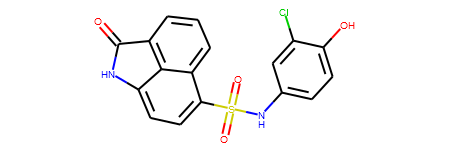

In [8]:
mols[0]

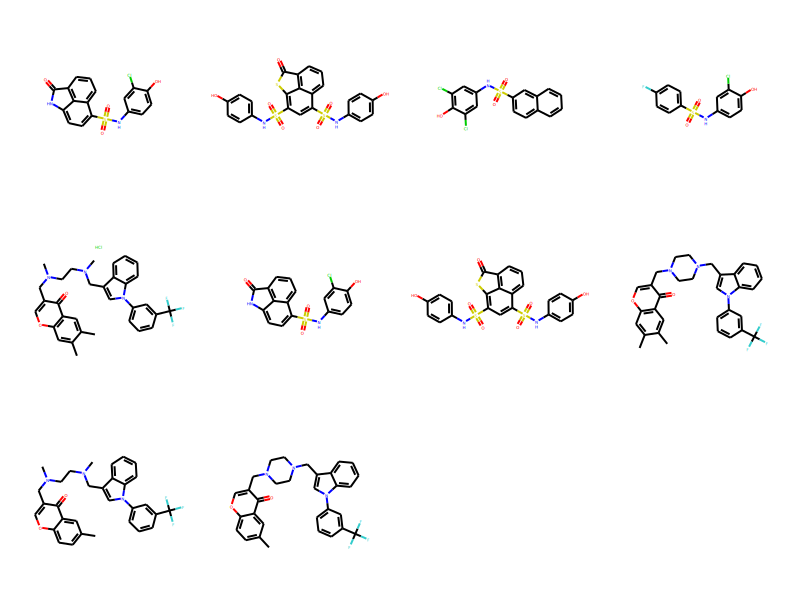

In [9]:
Draw.MolsToGridImage(mols[0:10], molsPerRow=4)

In [10]:
import nglview as nv

In [11]:
v = nv.NGLWidget()

In [12]:
nv.show_pdbid('6rmj')

NGLWidget()

In [13]:
mol = mols[0]
mol = AllChem.AddHs(mol)

In [14]:
AllChem.EmbedMolecule(mol)

0

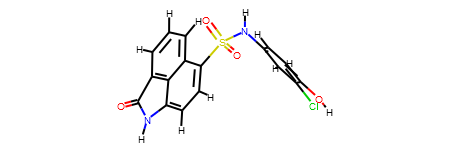

In [15]:
mol

In [16]:
nv.show_rdkit(mol)

NGLWidget()

In [17]:
ffact = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef'))

In [18]:
feats = ffact.GetFeaturesForMol(mol)

In [19]:
feats

(<rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature at 0x1cc828f7030>,
 <rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature at 0x1cc8292b510>)

In [20]:
feats[0].GetFamily()

'Donor'

In [21]:
feats_freq = collections.Counter([x.GetFamily() for x in feats])
feats_freq

Counter({'Donor': 3,
         'Acceptor': 4,
         'Aromatic': 3,
         'Hydrophobe': 13,
         'LumpedHydrophobe': 3})

In [22]:
p=pd.DataFrame(feats_freq, index=['molecule']).transpose()

In [23]:
p

,molecule
Donor,3
Acceptor,4
Aromatic,3
Hydrophobe,13
LumpedHydrophobe,3


In [24]:
acceptors = ffact.GetFeaturesForMol(mol, includeOnly='Acceptor')
donors = ffact.GetFeaturesForMol(mol, includeOnly='Donor')
hydrophobics = ffact.GetFeaturesForMol(mol, includeOnly='Hydrophobe')

In [25]:
features = {"donors": donors,
            "acceptors": acceptors,
            "hydrophobics": hydrophobics}

In [26]:
hydrophobics

(<rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature at 0x1cc82939c90>,
 <rdkit.Chem.rdMolChemicalFeatures.MolChemicalFeature at 0x1cc829541b0>)

In [27]:
pos = feats[0].GetPos()

In [28]:
pos.y

-2.504520864601761

In [29]:
feature_colors = {"donors": (0,0.9,0),  # Green
                  "acceptors": (0.9,0,0),  # Red 
                  "hydrophobics": (1,0.9,0)}  # Yellow

In [30]:
def show_ligand(rdkit_mol):
    v = nv.NGLWidget()
    c = v.add_component(Chem.MolToPDBBlock(mol), ext="pdb")
    c.clear()
    c.add_ball_and_stick()
    return v

In [31]:
show_ligand(mol)

NGLWidget()

In [32]:
def visualize_features(molecule, feature_type, features, color="yellow", sphere_radius=0.7):
    v = show_ligand(molecule)
    for feat in features:
        loc = list(feat.GetPos())
        label = f"{feature_type}"
        v.shape.add_sphere(loc, color, sphere_radius, label)
    return v

In [33]:
feature_type = "donors"
v = visualize_features(mol, feature_type, features[feature_type], feature_colors[feature_type])
v

NGLWidget()

In [34]:
feature_type = "acceptors"
v = visualize_features(mol, feature_type, features[feature_type], feature_colors[feature_type])
v

NGLWidget()

In [35]:
feature_type = "hydrophobics"
v = visualize_features(mol, feature_type, features[feature_type], feature_colors[feature_type])
v

NGLWidget()

In [36]:
al = Chem.rdMolAlign.AlignMolConformers(mol, maxIters=5)

In [37]:
show_ligand(al)

NGLWidget()

In [38]:
mol2 = AllChem.AddHs(mols[3])
AllChem.EmbedMolecule(mol2)

0

In [42]:
cids=AllChem.EmbedMultipleConfs(mol,pruneRmsThresh=1.0)

In [44]:
for cid in cids: AllChem.UFFOptimizeMolecule(mol,confId=cid)

In [49]:
core = Chem.MolFromSmarts('c12ncnc1ncnc2')

KekulizeException: Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8


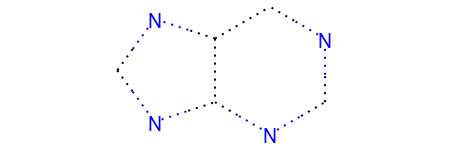

In [50]:
core